# Configuración inicial



Subir clave de kaggle

In [1]:
from google.colab import files
uploaded = files.upload()
!pip3 install kaggle

Saving kaggle.json to kaggle.json
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Mover la clave de kaggle a la ruta requerida

In [3]:
!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


Instalar librerías necesarias

In [4]:
!pip3 install pydicom
import kaggle
import zipfile
import glob
import os
import cv2
import numpy as np
import pydicom
import pandas as pd
from pathlib import Path
import pydicom
from matplotlib import pyplot as plt
from progressbar import ProgressBar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 13.9 MB/s 


Descargar los archivos del reto desde kaggle si no están ya descargados

In [5]:
if not os.path.exists('edemdataproject4.zip'):
  !kaggle competitions download -c edemdataproject4

100% 19.1G/19.1G [05:54<00:00, 60.3MB/s]
100% 19.1G/19.1G [05:54<00:00, 57.9MB/s]


Extraer los archivos del zip

In [6]:
# extraer archivos
if not (os.path.isdir('train') and os.path.isdir('test') and os.path.exists('sample_submission.csv') and os.path.exists('train.csv')):
  with zipfile.ZipFile("edemdataproject4.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

# eliminar el zip
if os.path.exists('edemdataproject4.zip'):
  !rm edemdataproject4.zip

# Vistazo a las imágenes

Crear una función para mostrar una imagen

In [7]:
def load_image(sample_path):
    ds = pydicom.dcmread(sample_path)
    img = ds.pixel_array
    p01 = np.percentile(img.ravel(), 1)
    p99 = np.percentile(img.ravel(), 99)
    img[img > p99] = p99
    img[img < p01] = p01
    if ds.data_element('PhotometricInterpretation').value == 'MONOCHROME1':
        img = np.invert(img)
    img = (img - img.min()) / (img.max() - img.min())
    return img

Guardar las rutas de todas las imágenes de train y test

In [8]:
all_train_files = glob.glob("train/*")
all_test_files = glob.glob("test/*")

Mostrar varias imágenes aleatorias

/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (15-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "
/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "


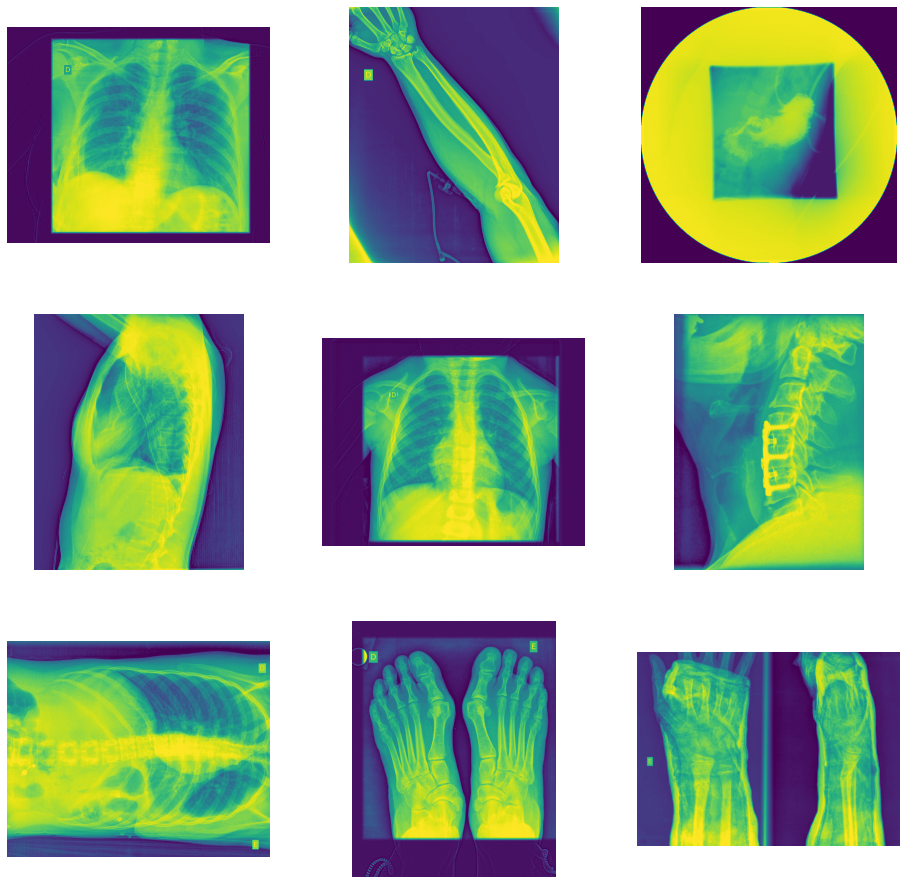

In [9]:
fig = plt.figure(figsize=(16, 16))
rows = 3
columns = 3
image_show = [None] * (rows * columns + 1)

# reading images
for i in range(1, rows*columns + 1):
  image_show[i] = load_image(Path(all_test_files[i]))

for i in range(1, rows*columns + 1):
  fig.add_subplot(rows, columns, i)
  plt.imshow(image_show[i])
  plt.axis('off')

# Obtención de la metadata

Leer archivo con los nombres y categorías de las imágenes de train

In [10]:
# leer csv con titulos y etiquetas de las imágenes
train_data = pd.read_csv('train.csv')

Diccionario para relacionar el id de la categoría con la descripción

In [11]:
bodyparts = {
    0 : 'Abdomen' ,
    1 :'Ankle' ,
    2 :'Cervical Spine',
    3 : 'Chest' ,
    4 :'Clavicles' ,
    5 :'Elbow' ,
    6 :'Feet' ,
    7 : 'Finger' ,
    8 : 'Forearm' ,
    9 : 'Hand' ,
    10 : 'Hip' ,
    11 : 'Knee' ,
    12 : 'Lower Leg' ,
    13 : 'Lumbar Spine' ,
    14 : 'Others' ,
    15 :'Pelvis',
    16 :'Shoulder' ,
    17 :'Sinus' ,
    18 : 'Skull' ,
    19 : 'Thigh' ,
    20 :'Thoracic Spine',
    21: 'Wrist',
}

Leer la metadata de todas las imágenes

In [12]:
train_img = list()
test_img = list()

pbar = ProgressBar()
n_files = 1
for name in pbar(all_train_files):
  train_img.append(pydicom.dcmread(name))
  n_files += 1

pbar2 = ProgressBar()
n_files = 1
for name in pbar2(all_test_files):
  test_img.append(pydicom.dcmread(name))
  n_files += 1

100% (1278 of 1278) |####################| Elapsed Time: 0:01:38 Time:  0:01:38
100% (328 of 328) |######################| Elapsed Time: 0:00:27 Time:  0:00:27


Ver la metadata de una de las imágenes

In [13]:
test_img[1]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 244
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.75938147298386832280002311650015738023
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.3.0.10
(0002, 0013) Implementation Version Name         SH: 'GDCM 3.0.10'
(0002, 0016) Source Application Entity Title     AE: 'gdcmconv'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) Instance Creation Time              TM: ''
(0008, 0016) SOP Class UID                       UI:

Guardar la metadata de train en un df

In [14]:
# extraer el nombre de la imagen
train_siuid = list(map(lambda x: x[0x0008, 0x0018].value, train_img))
# extraer el alto de la imagen
train_height = list(map(lambda x: x.Rows, train_img))
# extraer el ancho de la imagen
train_width = list(map(lambda x: x.Columns, train_img))

# extraer la edad del paciente de la imagen
train_age = list(
    map(lambda x: 
        int(x[0x0010, 0x1010].value.replace('Y', '')) 
        if len(x[0x0010, 0x1010].value) > 0 
        else float('NaN'), 
        train_img
        )
)
# extraer el sexo del paciente de la imagen
train_sex = list(
    map(lambda x: 
        int(x[0x0010, 0x0040].value.replace('Y', '')) 
        if len(x[0x0010, 0x0040].value) > 0 
        else float('NaN'), 
        train_img
        )
)

# juntar todo en un dataframe
train_features = pd.DataFrame(
    {
     'SOPInstanceUID': train_siuid,
     'width': train_width, 
     'height': train_height,
     'patient_age': train_age,
     'patient_sex': train_sex,
    }
)


# añadir la parte del cuerpo de cada imagen al dataframe
train_features = train_features.merge(train_data, on='SOPInstanceUID', how='left')
train_features['body_part'] = train_features.Target.map(bodyparts)
train_features.drop(columns=['Target'], inplace = True)

Ver algunos registros del dataframe

In [15]:
train_features.head(10)

,SOPInstanceUID,width,height,patient_age,patient_sex,body_part
0,1.2.826.0.1.3680043.8.498.10336027809141061948...,4240,3480,NaN,NaN,Chest
1,1.2.826.0.1.3680043.8.498.37634180084111795685...,3480,4240,NaN,NaN,Chest
2,1.2.826.0.1.3680043.8.498.37351105991005007794...,252,228,80.0,NaN,Others
3,1.2.826.0.1.3680043.8.498.65767022020470341089...,3480,4240,NaN,NaN,Chest
4,1.2.826.0.1.3680043.8.498.52603667446510125891...,4240,3480,NaN,NaN,Chest
5,1.2.826.0.1.3680043.8.498.47263066939228292739...,4240,3480,NaN,NaN,Knee
6,1.2.826.0.1.3680043.8.498.10674256341780119712...,4240,3480,NaN,NaN,Chest
7,1.2.826.0.1.3680043.8.498.30602672115002182933...,3480,4240,NaN,NaN,Abdomen
8,1.2.826.0.1.3680043.8.498.40359932981956163394...,3480,4240,NaN,NaN,Thigh
9,1.2.826.0.1.3680043.8.498.10677807821925693390...,2320,2920,NaN,NaN,Forearm


Guardar la metadata de test en otro dataframe

In [16]:
# extraer el nombre de la imagen
test_siuid = list(map(lambda x: x[0x0008, 0x0018].value, test_img))
# extraer el alto de la imagen
test_height = list(map(lambda x: x.Rows, test_img))
# extraer el ancho de la imagen
test_width = list(map(lambda x: x.Columns, test_img))

# extraer la edad del paciente de la imagen
test_age = list(
    map(lambda x: 
        int(x[0x0010, 0x1010].value.replace('Y', '')) 
        if len(x[0x0010, 0x1010].value) > 0 
        else float('NaN'), 
        test_img
        )
)

# extraer el sexo del paciente de la imagen
test_sex = list(
    map(lambda x: 
        int(x[0x0010, 0x0040].value.replace('Y', '')) 
        if len(x[0x0010, 0x0040].value) > 0 
        else float('NaN'), 
        test_img
        )
)

# juntar todo en un dataframe
test_features = pd.DataFrame(
    {
     'SOPInstanceUID': test_siuid,
     'width': test_width, 
     'height': test_height, 
     'patient_age': test_age,
     'patient_sex': test_sex,
    }
)

In [17]:
# ver algunos registros de la metadata de test
test_features.head(10)

,SOPInstanceUID,width,height,patient_age,patient_sex
0,1.2.826.0.1.3680043.8.498.82969626131424325774...,4240,3480,NaN,NaN
1,1.2.826.0.1.3680043.8.498.75938147298386832280...,4240,3480,NaN,NaN
2,1.2.826.0.1.3680043.8.498.95707977667044248997...,3480,4240,NaN,NaN
3,1.2.826.0.1.3680043.8.498.74830143260178495808...,1024,1024,NaN,NaN
4,1.2.826.0.1.3680043.8.498.86545232502450525182...,3480,4240,NaN,NaN
5,1.2.826.0.1.3680043.8.498.84220741654073964459...,2920,2320,NaN,NaN
6,1.2.826.0.1.3680043.8.498.98229201581139590153...,1720,2320,NaN,NaN
7,1.2.826.0.1.3680043.8.498.85211483184156833049...,4240,3480,NaN,NaN
8,1.2.826.0.1.3680043.8.498.98108959707366509428...,2320,2920,NaN,NaN
9,1.2.826.0.1.3680043.8.498.84026621469194649210...,2320,1720,NaN,NaN


# Analizar los metadatos de las imágenes

Ver los datos estadísticos de los dataframes

In [18]:
train_features.describe()

,width,height,patient_age,patient_sex
count,1278.000000,1278.000000,37.000000,0.0
mean,3237.946792,3274.844288,65.810811,NaN
std,1011.725482,928.641047,16.223847,NaN
min,128.000000,172.000000,10.000000,NaN
25%,2320.000000,2920.000000,60.000000,NaN
50%,3480.000000,3480.000000,70.000000,NaN
75%,4240.000000,4240.000000,75.000000,NaN
max,4240.000000,4240.000000,85.000000,NaN


In [19]:
test_features.describe()

,width,height,patient_age,patient_sex
count,328.000000,328.000000,11.000000,0.0
mean,3214.926829,3279.826220,60.909091,NaN
std,1018.005158,930.056075,26.815870,NaN
min,168.000000,212.000000,10.000000,NaN
25%,2320.000000,2920.000000,55.000000,NaN
50%,3480.000000,3480.000000,70.000000,NaN
75%,4240.000000,4240.000000,77.500000,NaN
max,4240.000000,4240.000000,85.000000,NaN


Las columna de edad no tiene prácticamente datos y la de sexo no tiene, por lo que no se usan en el modelo

Ver los valores de la columna objetivo

In [22]:
train_features['body_part'].value_counts()

Chest             579
Others             96
Knee               81
Abdomen            64
Cervical Spine     61
Feet               56
Pelvis             53
Wrist              50
Shoulder           32
Ankle              32
Lumbar Spine       31
Hand               24
Elbow              18
Sinus              18
Lower Leg          15
Hip                15
Finger             12
Thoracic Spine     12
Forearm             9
Skull               8
Clavicles           7
Thigh               5
Name: body_part, dtype: int64

In [23]:
train_features['body_part'].value_counts(normalize = True)['Chest']

0.45305164319248825

Se ve un claro desbalanceo entre las distintas categorías. Solo las imágenes de pecho forman el 45% del dataset de train

Ver las dimensiones de las imágenes

In [28]:
train_features.value_counts(["height", "width"])

height  width
3480    4240     439
4240    3480     382
2920    2320     174
2320    1720     103
        2920      78
1720    2320      45
1024    1024      18
192     252        3
230     252        2
2364    2964       2
292     300        2
290     300        2
278     300        2
282     300        2
232     252        1
238     252        1
196     252        1
202     252        1
210     252        1
214     252        1
216     252        1
218     252        1
220     252        1
351     128        1
314     300        1
302     300        1
300     300        1
296     300        1
294     300        1
222     252        1
224     252        1
288     300        1
284     300        1
226     252        1
228     252        1
268     300        1
256     300        1
172     252        1
dtype: int64

Como se ve, las imágenes no solo tienen distintos tamaños (Que son además muy elevados) si no que la proporción de estas no es igual para todas las imágenes

Ver un histograma con el alto de las imágenes en pixels de train y test

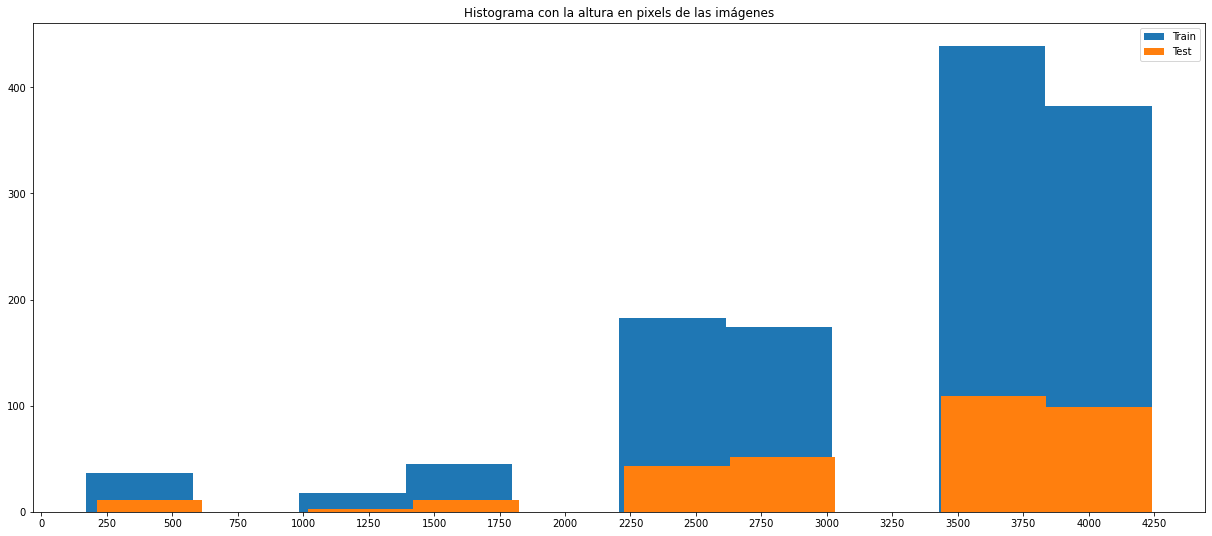

In [38]:
fig = plt.gcf()
fig.set_size_inches(21, 9)
plt.hist(train_features['height'])
plt.hist(test_features['height'])
plt.title('Histograma con la altura en pixels de las imágenes')
labels= ["Train","Test"]
plt.legend(labels)
plt.xticks(range(0, max(max(train_features['height']), max(test_features['height'])) + 250, 250))
plt.show()

Ver un histograma con el ancho de las imágenes en pixels de train y test

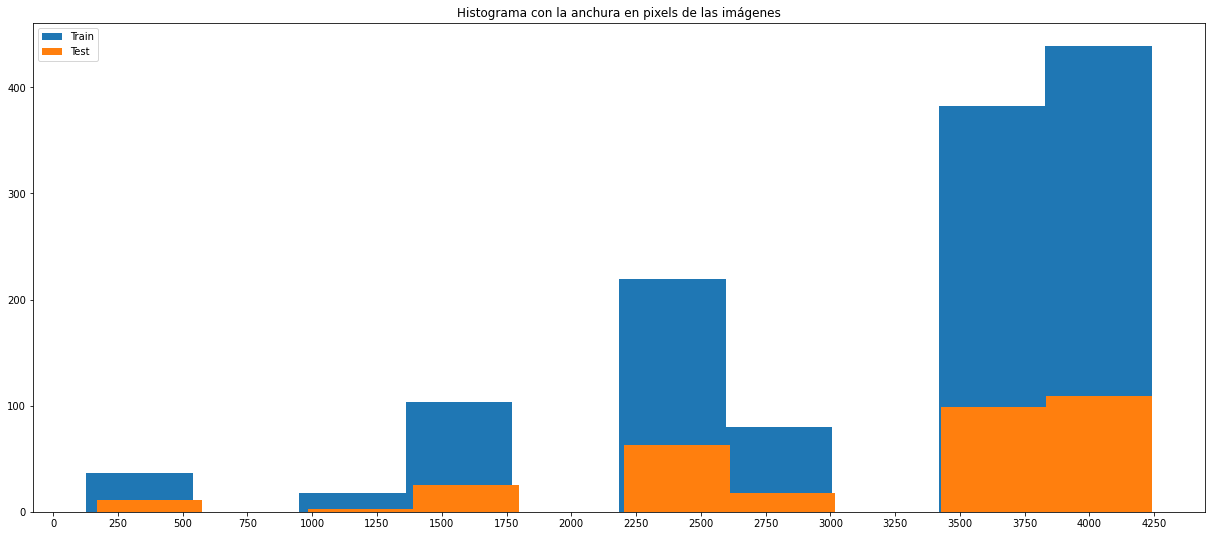

In [39]:
fig = plt.gcf()
fig.set_size_inches(21, 9)
plt.hist(train_features['width'])
plt.hist(test_features['width'])
plt.title('Histograma con la anchura en pixels de las imágenes')
labels= ["Train","Test"]
plt.legend(labels)
plt.xticks(range(0, max(max(train_features['width']), max(test_features['width'])) + 250, 250))
plt.show()

Mismos resultados que con la altura